- 각자 이 ipynb 파일의 **사본을 생성**하여 과제 Q0~Q3까지 채운 후 해당 파일을 깃허브에 업로드해주세요!

# RNN Sample Code in PyTorch

- 직접 읽어보며 돌려볼 수 있는 **쉬운** 예제 코드~
- 코드 간단 설명:
  - 길이 12짜리 binary sequence(0/1)를 입력으로 받아서, 시퀀스 안에 1-0-1 pattern이 한 번이라도 등장하면 1, 아니면 0을 맞추는 binary classification을 수행하는 RNN 분류기
  - 마지막에는 demo sequence로 예측 + hidden state 변화까지 출력하는 프로그램

In [80]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

- 정답 label 만드는 함수
- 역할:
  - sequence(e.g., [1,0,1,0,0,...]) 안에 연속된 3칸이 1-0-1인 구간이 있는지 검사
  - 있으면 label=1 / 없으면 label=0

In [81]:
def has_101_pattern(seq):
    for i in range(len(seq) - 2):
        if seq[i] == 1 and seq[i+1] == 0 and seq[i+2] == 1:
            return 1
    return 0

- 학습용 data 만드는 PatternDataset 클래스
- 깨알 상식) PyTorch에서 Dataset은 "데이터를 꺼내는 방식"을 표준화한 클래스~
  - 이걸 상속받아서 내가 하고자 하는 task에 부합하는 나만의 커스텀 Dataset 클래스를 만들어서 모델에 먹이는 겁니다 얍얍

In [82]:
# Dataset이 하는 일은 "모델에 넣기 좋은 형태"로 데이터를 제공하는 것!
class PatternDataset(Dataset):
    def __init__(self, n_samples=5000, seq_len=12):
        self.data = []
        # (입력 시퀀스, 정답 label)을 n_samples개만큼 저장
        for _ in range(n_samples):
            seq = [random.randint(0, 1) for _ in range(seq_len)]  # 1) seq_len 길이의 random sequence 생성(0/1)
            label = has_101_pattern(seq)                          # 2) has_101_pattern(seq)로 정답 label 생성
            self.data.append((seq, label))                        # 3) (seq, label)을 self.data에 저장

    # Dataset 안에 sample이 몇 개인지 알려주는 매직 메소드!
    # 이걸로 보통 DataLoader가 "전체 크기"를 알 수 있게 합니다
    def __len__(self):
        return len(self.data)

    # idx번째 데이터를 꺼내서 pytorch tensor로 변환해주는 매직 메소드
    def __getitem__(self, idx):
        seq, label = self.data[idx]
        x = torch.tensor(seq, dtype=torch.long)         # (T,) = (12,) / embedding은 정수 인덱스를 받기 때문에 dtype으로 long을 사용합니다!
        y = torch.tensor(label, dtype=torch.float32)    # scalar / BCEWithLogitsLoss가 float label(0.0/1.0)을 기대하는 편이라 dtype으로 float32를 사용했어요
        return x, y

- RNN 모델 클래스
- pytorch에서 모델 클래스는 일반적으로 nn.Module을 상속해서 만들어요~

In [83]:
class SimpleRNNClassifier(nn.Module):
    def __init__(self, vocab_size=2, embed_dim=8, hidden_dim=16):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)  # 학습 연산을 위해 (0/1) -> '벡터'로 변환
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True) # sequence를 왼쪽부터 읽으면서 hidden state를 update
        self.fc = nn.Linear(hidden_dim, 1) # 마지막 hidden state로 이진 분류 점수(logit) 출력

    # 일반 학습/평가용 feedforward 순전파 함수
    def forward(self, x):
        """
        NOTE: B는 batch size, T는 시퀀스의 길이!

        input x: (B, T) 0/1 token
        return: logits (B,)
        """
        emb = self.embed(x)            # (B, T, E) / 벡터화
        out, h_n = self.rnn(emb)       # 각 시점의 hidden 기록인 out: (B, T, H) / 마지막 hidden state인 h_n: (1, B, H)
        last_h = h_n[-1]               # (B, H) / 마지막 hidden만 추출
        logits = self.fc(last_h)       # (B, H) -> (B, 1)
        return logits.squeeze(1)       # (B,) / loss 계산 편하게 하기 위해 주로 이렇게 squeeze()라는 함수를 사용하여 모양을 맞춰줍니다

    def forward_with_trace(self, x):
        """
        시각화를 통해 이해할 수 있도록 time step별 hidden(out)과 마지막 예측(logits)을 함께 리턴하는 함수
        x: (1, T) 단일 시퀀스만 넣는 것을 권장함
        """
        emb = self.embed(x)            # (1, T, E)
        out, h_n = self.rnn(emb)       # out: (1, T, H)
        last_h = h_n[-1]               # (1, H)
        logits = self.fc(last_h)       # (1, 1)
        return logits.squeeze(1), out.squeeze(0)  # logits: (1,), out: (T, H)
        # out.squeeze(0) 추가로 한 이유 : batch=1을 넣으면 shape이 (1,T,H)인데 이 batch의 차원(1)을 제거하여 (T,H)로 보기 좋게 만든것!
        # (크게 중요한 건 아닌데 그냥 궁금하실까봐,,)

- 메인 함수: train()
- 내부 로직 STEP BY STEP 설명:
  1. (train/val) dataset 생성
  2. DataLoader로 배치 묶기
  3. model / loss function / optimizer 준비
  4. epoch 반복하며 train
  5. epoch마다 검증(val) 정확도 출력
  6. 마지막에 demo sequence 1개 넣어서 확률 출력
  7. demo sequence에서 시간별 hidden state 일부 출력

In [84]:
def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    """
    <헷갈리는 개념 (코드 지피티 딸깍하지 말고 이젠 꼭 알아두자)>
    - Dataset: 데이터 1개를 어떻게 꺼낼지 정의
    - DataLoader: 여러 개를 묶어서 batch를 만들고, 섞고, 반복 가능한 형태로 제공
    - shuffle : train은 섞어서 학습이 안정적이고 (True) / val은 평가하는 거니까 섞을 필요 없음 (False)
    """

    train_ds = PatternDataset(n_samples=6000, seq_len=12)
    val_ds   = PatternDataset(n_samples=1000, seq_len=12)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

    # model/loss function/optimizer 준비
    model = SimpleRNNClassifier(embed_dim=8, hidden_dim=16).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # Epoch train loop
    for epoch in range(1, 6):
        model.train()                                   # dropout/batch regularization 등의 mode들이 train 모드로 바뀜
        total_loss = 0.0

        for x, y in train_loader:                       # batch 단위로 (x, y) 받음
            x, y = x.to(device), y.to(device)           # x:(B,T), y:(B,)

            logits = model(x)                           # (B,) / forward 실행
            loss = criterion(logits, y)                 # scalar값 (정답 y와 예측 점수인 logit을 비교하여 loss값 계산)

            optimizer.zero_grad()                       # 이전 gradient를 0으로
            loss.backward()                             # backpropagation
            optimizer.step()                            # parameter update

            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)

        # validation
        model.eval()                                    # 평가 모드
        correct, total = 0, 0
        with torch.no_grad():                           # 평가이므로 학습 때와 달리 gradient 계산 하지 않음
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                probs = torch.sigmoid(logits)
                preds = (probs >= 0.5).float()          # 0.5 이상이면 1로 예측하도록 구현
                correct += (preds == y).sum().item()
                total += y.numel()

        val_acc = correct / total
        print(f"[Epoch {epoch}] train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")

    # ----------------------------
    # DEMO: hidden state 흐름을 출력해보자!
    # ----------------------------
    model.eval()

    demo_seq = [1,1,0,0,1,1,0,0,1,1,0,0]  # 패턴 101이 있는 입력 시퀀스
    demo = torch.tensor([demo_seq], dtype=torch.long).to(device)  # (1,T)

    with torch.no_grad():
        logit, h_trace = model.forward_with_trace(demo)
        prob = torch.sigmoid(logit).item()

    print("\n=== Demo ===")
    print("Sequence:", demo_seq)
    print("Final prob(pattern=101):", round(prob, 4))

    # hidden trace 일부 출력(앞 3스텝 + 마지막 3스텝)
    h_cpu = h_trace.cpu()  # (T,H)
    print("\nHidden state trace (show first 3 and last 3 time steps):")
    for t in list(range(3)) + list(range(len(demo_seq)-3, len(demo_seq))):
        vec = h_cpu[t][:6].tolist()  # hidden_dim 16 중 앞 6개만 보기
        vec = [round(v, 3) for v in vec]
        print(f"t={t:2d}, x_t={demo_seq[t]} -> h_t[:6]={vec}")

if __name__ == "__main__":
    train()

[Epoch 1] train_loss=0.6012  val_acc=0.7250
[Epoch 2] train_loss=0.5751  val_acc=0.7250
[Epoch 3] train_loss=0.5202  val_acc=0.7810
[Epoch 4] train_loss=0.4477  val_acc=0.8170
[Epoch 5] train_loss=0.2632  val_acc=0.9510

=== Demo ===
Sequence: [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0]
Final prob(pattern=101): 0.3995

Hidden state trace (show first 3 and last 3 time steps):
t= 0, x_t=1 -> h_t[:6]=[-0.656, -0.213, -0.257, 0.401, 0.319, 0.845]
t= 1, x_t=1 -> h_t[:6]=[-0.845, -0.593, -0.475, 0.552, 0.322, 0.977]
t= 2, x_t=0 -> h_t[:6]=[0.959, 0.923, -0.449, -0.847, 0.637, 0.461]
t= 9, x_t=1 -> h_t[:6]=[-0.908, -0.644, -0.737, 0.356, 0.589, 0.986]
t=10, x_t=0 -> h_t[:6]=[0.967, 0.922, -0.79, -0.863, 0.807, 0.36]
t=11, x_t=0 -> h_t[:6]=[0.998, 0.995, -0.332, -0.987, 0.477, -0.504]


- 위 코드에서 demo_seq 변수를 아래 두 가지로 바꿔서 각각 실행해보세요~
  - 패턴 있음: [1,0,1,0,0,0,0,0,0,0,0,0] → 확률 높아야 함
  - 패턴 없음: [1,1,0,0,1,1,0,0,1,1,0,0] → 확률 낮아야 함

### Q0. 위 코드의 출력 결과 분석 & 두 가지 입력을 넣었을 때 각각의 결과를 비교 분석하시오.

Ans) 
위 코드는 에폭5까지의 loss와 accuracy를 보여주는데, 에폭이 진행될수록 loss는 줄고 accuracy는 오르는 것을 볼 수 있어 모델이 패턴을 찾는 규칙을 파악했다고 볼 수 있다.
hidden state는 시간의 진행과 그때의 x값을 보여주며 패턴을 학습하는 모습을 보여준다.
패턴이 있는 [1,0,1,0,0,0,0,0,0,0,0,0]은 0.9666, 패턴이 없는 [1,1,0,0,1,1,0,0,1,1,0,0]은 0.3995로 각각 0.5보다 크거나 작게 알맞은 결과가 나왔다. 

# LSTM Sample code in PyTorch

- 아래는 위와 동일하게 진행

In [85]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [86]:
def has_101_pattern(seq):
    for i in range(len(seq) - 2):
        if seq[i] == 1 and seq[i+1] == 0 and seq[i+2] == 1:
            return 1
    return 0

In [87]:
class PatternDataset(Dataset):
    def __init__(self, n_samples=5000, seq_len=12):
        self.data = []
        for _ in range(n_samples):
            seq = [random.randint(0, 1) for _ in range(seq_len)]
            label = has_101_pattern(seq)
            self.data.append((seq, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        x = torch.tensor(seq, dtype=torch.long)
        y = torch.tensor([label], dtype=torch.float)
        return x, y

- 여기서부터 LSTM 모델 클래스

In [88]:
class SimpleLSTMClassifier(nn.Module):
    def __init__(self, vocab_size=2, embed_dim=8, hidden_dim=16):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)  # (0/1) -> 벡터로 변환
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embed(x)                         # (batch, seq_len, embed_dim)
        out, (h_n, c_n) = self.lstm(emb)            # out: (batch, seq_len, hidden_dim)
                                                    # h_n: (num_layers, batch, hidden_dim)
                                                    # c_n: (num_layers, batch, hidden_dim)

        last_h = h_n[-1]                            # (batch, hidden_dim)  마지막 layer의 마지막 hidden
        logit = self.fc(last_h)                     # (batch, 1)
        return logit, out, (h_n, c_n)


RNN과의 차이점??

1. nn.RNN -> nn.LSTM
2. lSTM은 hidden state(h) 말고도 cell state(c)가 추가되었다는 점
3. forward 결과에 따른 형태? (output, (h_n, c_n))

- 메인 함수 : train()
- 내부 로직 step by step 설명:
  1. train, val dataset 생성
  2. DataLoader로 배치 묶기
  3. model, loss function, optimizer 준비
  4. epoch 반복하며 train
  5. epoch마다 검증 정확도 출력
  6. 마지막에 demo seq 하나 넣어서 확률 출력
  7. demo seq에서 시간별 hidden state 출력

In [89]:
def train():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_ds = PatternDataset(n_samples=6000, seq_len=12)
    val_ds   = PatternDataset(n_samples=1000, seq_len=12)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

    model = SimpleLSTMClassifier(vocab_size=2, embed_dim=8, hidden_dim=16).to(device)
    criterion = nn.BCEWithLogitsLoss()  # logit을 바로 넣는 BCE
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    n_epochs = 5

    for epoch in range(1, n_epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)               # x:(B,12), y:(B,1)
            optimizer.zero_grad()

            logit, _, _ = model(x)                           # logit:(B,1)
            loss = criterion(logit, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(train_ds)

        # ---- val ----
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logit, _, _ = model(x)
                prob = torch.sigmoid(logit)                  # (B,1)
                pred = (prob >= 0.5).float()                 # (B,1)
                correct += (pred == y).sum().item()
                total += y.numel()

        acc = correct / total
        print(f"[Epoch {epoch:02d}] loss={avg_loss:.4f} | val_acc={acc:.4f}")

    # ---- demo ----
    model.eval()

    demo_seq = [1,0,1,0,0,0,1,1,0,0,0,0] # 패턴 없음 -> 확률 낮아야 함

    x_demo = torch.tensor(demo_seq, dtype=torch.long).unsqueeze(0).to(device)  # (1, 12)
    logit, out_all, (h_n, c_n) = model(x_demo)

    prob = torch.sigmoid(logit).item()
    print("\n--- DEMO ---")
    print("demo_seq:", demo_seq)
    print(f"pred_prob(pattern=1): {prob:.4f}")

    # 시간별 hidden state 일부 출력
    # out_all: (1, seq_len, hidden_dim)  -> time step별 hidden이 들어있음 (LSTM의 output)
    out_all = out_all.squeeze(0).detach().cpu()  # (seq_len, hidden_dim)

    print("\n[time step별 hidden state 앞 6개 차원만 출력]")
    for t in range(out_all.size(0)):
        h_t = out_all[t, :6].numpy()
        print(f"t={t:02d}, x={demo_seq[t]} -> h_t[:6]={h_t}")

    # (참고) 마지막 hidden/cell state도 같이 보기
    last_h = h_n[-1].squeeze(0).detach().cpu()    # (hidden_dim,)
    last_c = c_n[-1].squeeze(0).detach().cpu()    # (hidden_dim,)
    print("\n[마지막 state 요약]")
    print("last_h[:6] =", last_h[:6].numpy())
    print("last_c[:6] =", last_c[:6].numpy())

    return model

돌려돌려

In [90]:
model = train()

[Epoch 01] loss=0.6053 | val_acc=0.7520
[Epoch 02] loss=0.5231 | val_acc=0.7790
[Epoch 03] loss=0.4921 | val_acc=0.7830
[Epoch 04] loss=0.3841 | val_acc=0.8850
[Epoch 05] loss=0.2016 | val_acc=0.9930

--- DEMO ---
demo_seq: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
pred_prob(pattern=1): 0.9825

[time step별 hidden state 앞 6개 차원만 출력]
t=00, x=1 -> h_t[:6]=[-0.14174482 -0.08512197  0.08501675  0.0131529   0.31470555 -0.37746838]
t=01, x=0 -> h_t[:6]=[-0.19705339 -0.61866325  0.6823895  -0.22395273  0.09037465 -0.14640789]
t=02, x=1 -> h_t[:6]=[-0.48691863 -0.03071117  0.05138782 -0.41100624  0.7116504  -0.72449905]
t=03, x=0 -> h_t[:6]=[-0.6413352  -0.3942228   0.8106143  -0.58283067  0.62902397 -0.6043566 ]
t=04, x=0 -> h_t[:6]=[-0.33412886 -0.00416821  0.59450585 -0.7977264   0.7439764  -0.5170861 ]
t=05, x=0 -> h_t[:6]=[-0.25388196  0.01199484  0.65564144 -0.86128384  0.8482886  -0.48781684]
t=06, x=1 -> h_t[:6]=[-0.65437245 -0.02250233  0.12161121 -0.955305    0.9512752  -0.793125  ]
t=07, 

- RNN과 비교할 점 :
  1. val_acc
  2. train_loss
  3. demo prob


- RNN vs LSTM

  현재는 장기기억이 필요 없어서 유사한 상황.
  
  trade-off 중요성

# GRU Sample code in PyTorch

In [91]:
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [92]:
def has_101_pattern(seq):
    for i in range(len(seq) - 2):
        if seq[i] == 1 and seq[i+1] == 0 and seq[i+2] == 1:
            return 1
    return 0

In [93]:
class PatternDataset(Dataset):
    def __init__(self, n_samples=5000, seq_len=12):
        self.data = []
        for _ in range(n_samples):
            seq = [random.randint(0, 1) for _ in range(seq_len)]
            label = has_101_pattern(seq)
            self.data.append((seq, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        x = torch.tensor(seq, dtype=torch.long)
        y = torch.tensor([label], dtype=torch.float)
        return x, y

- GRU 클래스:
  nn.GRU
  
  LSTM처럼 cell state(c)가 없고, hidden state(h) 하나만 유지

  forward 결과로 out, h_n
  
  out : 모든 time step의 hidden (batch, seq_len, hidden_dim)

  h_n : 마지막 hidden (num_layers, batch, hidden_dim)

In [94]:
class SimpleGRUClassifier(nn.Module):
    def __init__(self, vocab_size=2, embed_dim=8, hidden_dim=16):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        emb = self.embed(x)                 # (B, T, E)
        out, h_n = self.gru(emb)            # out: (B, T, H), h_n: (1, B, H)
        last_h = h_n[-1]                    # (B, H)
        logit = self.fc(last_h)             # (B, 1)
        return logit, out, h_n

In [95]:
def train_gru():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    train_ds = PatternDataset(n_samples=6000, seq_len=12)
    val_ds   = PatternDataset(n_samples=1000, seq_len=12)

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

    model = SimpleGRUClassifier(vocab_size=2, embed_dim=8, hidden_dim=16).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    n_epochs = 5

    for epoch in range(1, n_epochs + 1):
        # ---- train ----
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            logit, _, _ = model(x)
            loss = criterion(logit, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * x.size(0)

        avg_loss = total_loss / len(train_ds)

        # ---- val ----
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logit, _, _ = model(x)
                prob = torch.sigmoid(logit)
                pred = (prob >= 0.5).float()
                correct += (pred == y).sum().item()
                total += y.numel()

        acc = correct / total
        print(f"[Epoch {epoch}] train_loss={avg_loss:.4f}  val_acc={acc:.4f}")

    # ---- demo ----
    model.eval()

    demo_seq = [1,0,1,0,0,0,1,1,0,0,0,0]  # 패턴 있음
    x_demo = torch.tensor(demo_seq, dtype=torch.long).unsqueeze(0).to(device)  # (1, 12)

    logit, out_all, h_n = model(x_demo)
    prob = torch.sigmoid(logit).item()

    print("\n=== Demo ===")
    print("Sequence:", demo_seq)
    print(f"Final prob(pattern=101): {prob:.4f}")

    # time step별 hidden state 출력 (앞 6개 차원)
    out_all = out_all.squeeze(0).detach().cpu()  # (T, H)

    print("\nHidden state trace (show first 3 and last 3 time steps):")
    T = out_all.size(0)
    for t in list(range(3)) + list(range(T-3, T)):
        h_t = out_all[t, :6].numpy()
        # 보기 좋게 소수점 3자리로
        h_t_fmt = [float(f"{v:.3f}") for v in h_t]
        print(f"t={t:2d}, x_t={demo_seq[t]} -> h_t[:6]={h_t_fmt}")

    return model

In [96]:
gru_model = train_gru()

[Epoch 1] train_loss=0.6305  val_acc=0.7640
[Epoch 2] train_loss=0.5555  val_acc=0.7670
[Epoch 3] train_loss=0.5150  val_acc=0.7830
[Epoch 4] train_loss=0.4613  val_acc=0.8280
[Epoch 5] train_loss=0.2547  val_acc=0.9960

=== Demo ===
Sequence: [1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
Final prob(pattern=101): 0.9818

Hidden state trace (show first 3 and last 3 time steps):
t= 0, x_t=1 -> h_t[:6]=[0.555, 0.392, -0.015, -0.27, -0.441, 0.004]
t= 1, x_t=0 -> h_t[:6]=[0.038, -0.735, 0.008, 0.24, -0.387, -0.219]
t= 2, x_t=1 -> h_t[:6]=[0.794, -0.588, 0.734, -0.753, -0.832, -0.196]
t= 9, x_t=0 -> h_t[:6]=[0.9, -0.927, 0.977, -0.938, -0.898, -0.939]
t=10, x_t=0 -> h_t[:6]=[0.895, -0.947, 0.977, -0.934, -0.892, -0.936]
t=11, x_t=0 -> h_t[:6]=[0.893, -0.958, 0.976, -0.932, -0.888, -0.934]


- LSTM vs GRU ?

# LSTM & GRU 과제

모델의 장기기억 성능을 비교하기 위한 코드입니다.

코드 중간의 빈칸을 채우면서, 매애앤 아래의 답변을 채워주시면 됩니다.

모르면 인공지능을 사용해도 좋지만, sample code로도 풀 수 있으니 최대한 본인의 힘으로 해보면 좋겠습니다 !!

In [97]:
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [98]:
# tmi) 11/7은 제 생일입니다. 감사합니다.
def set_seed(seed=117):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(117)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [99]:
class LongMemoryDataset(Dataset):

    def __init__(self, n_samples=8000, T=80):
        self.T = T
        self.data = []
        for _ in range(n_samples):
            first_bit = random.randint(0, 1)          # 기억해야 할 정보
            middle = [random.randint(0, 1) for _ in range(T-2)]
            seq = [first_bit] + middle + [2]          # 마지막은 DELIM=2
            label = first_bit
            self.data.append((seq, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        x = torch.tensor(seq, dtype=torch.long)               # (T,)
        y = torch.tensor([label], dtype=torch.float)          # (1,)
        return x, y

1. lstm 모델 빈칸 채우기

In [126]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size=3, embed_dim=8, hidden_dim=32):
        super().__init__()
        # TODO : 임베딩 레이어를 선언하세요.
        self.embed = nn.Embedding(vocab_size, embed_dim)
        # TODO : LSTM 레이어를 선언하세요. (batch_first=True)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, T)
        # TODO: 임베딩을 통과시키세요.
        emb = self.embed(x)
        # TODO : LSTM에 넣고 out, (h_n, c_n)을 받으세요.
        out, (h_n, c_n) = self.lstm(emb)
        # TODO : 마지막 hidden(last_h)을 얻으세요.
        last_h = h_n[-1]
        logit = self.fc(last_h)
        return logit, out, (h_n, c_n)


2. gru 모델 빈칸 채우기

In [131]:
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size=3, embed_dim=8, hidden_dim=32):
        super().__init__()
        # TODO : 임베딩 레이어
        self.embed = nn.Embedding(vocab_size, embed_dim)
        # TODO : GRU 레이어 (batch_first=True)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (B, T)
        # TODO : 임베딩
        emb = self.embed(x)
        # TODO : GRU forward로 out, h_n 받기
        out, h_n = self.gru(emb)
        # TODO : 마지막 hidden
        last_h = h_n[-1]
        logit = self.fc(last_h)
        return logit, out, h_n


학습 루프 만들기

In [134]:
def train_model(model, train_loader, val_loader, epochs=6, lr=1e-3, device="cpu", tag=""):
    model = model.to(device)
    # TODO : loss 함수 선언 (BCEWithLogitsLoss)
    crit = nn.BCEWithLogitsLoss()
    # TODO : optimizer 선언 (Adam)
    opt = torch.optim.Adam(model.parameters(),lr=lr)

    #추가:그래프를 위해 loss history만들기
    history = {"train_loss": [], "val_acc": []}
    

    for ep in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        n = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            # TODO : gradient 초기화
            opt.zero_grad()
            out = model(x)
            logit = out[0] if isinstance(out, (tuple, list)) else out

            # TODO : loss 계산
            loss = crit(logit,y.float())
            # TODO : backprop
            loss.backward()
            # TODO : optimizer step
            opt.step()

            total_loss += loss.item() * x.size(0)
            n += x.size(0)

        train_loss = total_loss / n
        history["train_loss"].append(train_loss)

        # validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                logit = out[0] if isinstance(out, (tuple, list)) else out

                # TODO : prob = sigmoid(logit)
                prob = torch.sigmoid(logit)
                # TODO : pred = (prob >= 0.5)
                pred = (prob >= 0.5).float() 


                correct += (pred == y).sum().item()
                total += y.numel()

        val_acc = correct / total
        print(f"{tag}[Epoch {ep}] train_loss={train_loss:.4f}  val_acc={val_acc:.4f}")
        history["val_acc"].append(val_acc)

    return model, history


In [135]:
# 그대로 실행하시면 됩니다.

T = 80
train_ds = LongMemoryDataset(n_samples=8000, T=T)
val_ds   = LongMemoryDataset(n_samples=2000, T=T)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)

lstm = LSTMClassifier(vocab_size=3, embed_dim=8, hidden_dim=32)
gru  = GRUClassifier(vocab_size=3, embed_dim=8, hidden_dim=32)

print("=== LSTM ===")
lstm = train_model(lstm, train_loader, val_loader, epochs=6, lr=1e-3, device=device, tag="LSTM ")

print("\n=== GRU ===")
gru = train_model(gru, train_loader, val_loader, epochs=6, lr=1e-3, device=device, tag="GRU  ")

=== LSTM ===
LSTM [Epoch 1] train_loss=0.6937  val_acc=0.4860
LSTM [Epoch 2] train_loss=0.6934  val_acc=0.4860
LSTM [Epoch 3] train_loss=0.6934  val_acc=0.4860
LSTM [Epoch 4] train_loss=0.6934  val_acc=0.4840
LSTM [Epoch 5] train_loss=0.6935  val_acc=0.5180
LSTM [Epoch 6] train_loss=0.6933  val_acc=0.4840

=== GRU ===
GRU  [Epoch 1] train_loss=0.6946  val_acc=0.4825
GRU  [Epoch 2] train_loss=0.6935  val_acc=0.5140
GRU  [Epoch 3] train_loss=0.6933  val_acc=0.4845
GRU  [Epoch 4] train_loss=0.6935  val_acc=0.4860
GRU  [Epoch 5] train_loss=0.6933  val_acc=0.5140
GRU  [Epoch 6] train_loss=0.6933  val_acc=0.5140


### Q1. LSTM과 GRU의 차이점에 대해서 간략하게 서술해주세요.

Ans) GRU는 hidden state로만 과거 정보를 기억해 구조가 단순하고 연산 효율이 좋은 반면, LSTM는 cell state를 따로 두어 기울기 소실 문제를 해결했다. 계산량이 조금 많지만 복잡한 장기기억에 유리하다.

### Q2. T=80에서 LSTM과 GRU의 학습 곡선을 비교하고, 어느 쪽이 더 안정적으로 수렴했는지 서술해주세요.

LSTM [Epoch 1] train_loss=0.6935  val_acc=0.5140
LSTM [Epoch 2] train_loss=0.6933  val_acc=0.4860
LSTM [Epoch 3] train_loss=0.6933  val_acc=0.4860
LSTM [Epoch 4] train_loss=0.6932  val_acc=0.4850
LSTM [Epoch 5] train_loss=0.6932  val_acc=0.5140
LSTM [Epoch 6] train_loss=0.6933  val_acc=0.5195
GRU  [Epoch 1] train_loss=0.6938  val_acc=0.5140
GRU  [Epoch 2] train_loss=0.6933  val_acc=0.5140
GRU  [Epoch 3] train_loss=0.6934  val_acc=0.4890
GRU  [Epoch 4] train_loss=0.6934  val_acc=0.4860
GRU  [Epoch 5] train_loss=0.6933  val_acc=0.4915
GRU  [Epoch 6] train_loss=0.6932  val_acc=0.5105


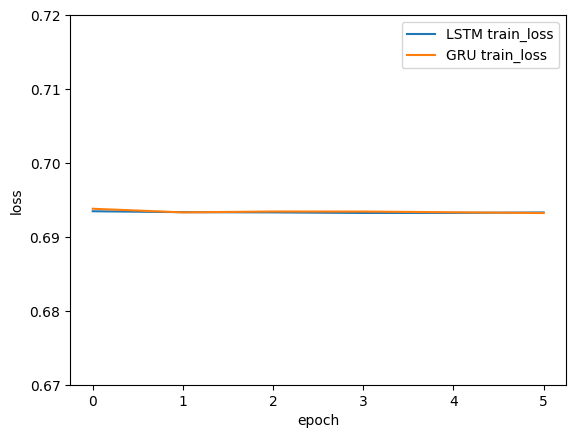

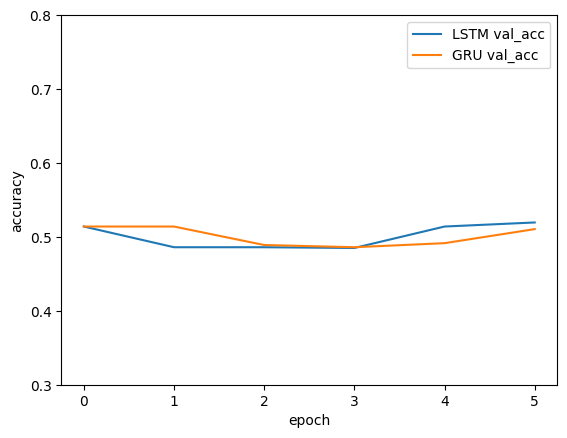

In [148]:
import matplotlib.pyplot as plt

lstm = LSTMClassifier()
lstm, h_lstm = train_model(lstm, train_loader, val_loader, epochs=6, lr=1e-3, device=device, tag="LSTM ")

gru = GRUClassifier()
gru, h_gru = train_model(gru, train_loader, val_loader, epochs=6, lr=1e-3, device=device, tag="GRU  ")

# train loss curve
plt.figure()
plt.plot(h_lstm["train_loss"], label="LSTM train_loss")
plt.plot(h_gru["train_loss"], label="GRU train_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.ylim(0.67,0.72)
plt.show()

# val acc curve
plt.figure()
plt.plot(h_lstm["val_acc"], label="LSTM val_acc")
plt.plot(h_gru["val_acc"], label="GRU val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()
plt.ylim(0.3,0.8)
plt.show()


Ans) T=80은 시퀀스가 짧기에 cell state를 따로 둘 필요가 없는 GRU가 성능이 더 좋기를 기대했으나 막상 비슷한 결과가 나왔다. 아마 데이터가 적고 구조가 쉬웠기 때문에 비슷한 정확도와 loss가 나온 것 같다. 대신 내부적으로는 GRU가 더 간단한 구조를 가지고 파라미터 수도 저기 때문에 학습속도가 더 빨랐을 것 같다.

### Q3. T를 80 → 150 → 300 순으로 늘려서 각각 실행해보고, 어떤 모델이 성능을 더 잘 유지하는지, 왜 그런 것 같은지를 서술해주세요.

Ans) LSTM이 성능을 더 잘 유지한다. 현재 출력되는 연산공간인 hidden state와는 별도로 cell state를 두어 오래된 시점의 데이터에 대한 기울기 소실 문제를 해결했기 때문에 정보를 더 오래 기억할 수 있고, 따라서 긴 시퀀스의 연산에서 장점이 두드러진다. 